In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
sys.path.insert(0, str(project_root))

print("Added to sys.path:", project_root)

Added to sys.path: c:\Users\adroz\OneDrive - Stormgeo AS\Desktop\od_zera_do_ai\modul_9\halfmarathon-predictor


In [2]:
import os
from dotenv import load_dotenv, find_dotenv

env_path = find_dotenv()
print("ENV PATH:", env_path)

load_dotenv(env_path, override=True)

DO_SPACES_KEY = os.getenv("DO_SPACES_KEY")
DO_SPACES_SECRET = os.getenv("DO_SPACES_SECRET")
DO_SPACES_REGION = os.getenv("DO_SPACES_REGION")
DO_SPACES_BUCKET = os.getenv("DO_SPACES_BUCKET")
DO_SPACES_PREFIX = os.getenv("DO_SPACES_PREFIX")

print("KEY starts with:", None if not DO_SPACES_KEY else DO_SPACES_KEY[:4])
print("SECRET present:", DO_SPACES_SECRET is not None, "len:", 0 if not DO_SPACES_SECRET else len(DO_SPACES_SECRET))
print(DO_SPACES_REGION, DO_SPACES_BUCKET, DO_SPACES_PREFIX)


ENV PATH: c:\Users\adroz\OneDrive - Stormgeo AS\Desktop\od_zera_do_ai\modul_9\halfmarathon-predictor\.env
KEY starts with: DO00
SECRET present: True len: 43
fra1 halfmarathon--data datasets/halfmarathon


In [3]:
import s3fs

fs = s3fs.S3FileSystem(
    key=DO_SPACES_KEY,
    secret=DO_SPACES_SECRET,
    client_kwargs={
        "endpoint_url": f"https://{DO_SPACES_REGION}.digitaloceanspaces.com"
    },
    config_kwargs={
        "signature_version": "s3v4"
    }
)

fs.ls(f"{DO_SPACES_BUCKET}/{DO_SPACES_PREFIX}")


['halfmarathon--data/datasets/halfmarathon/2023.csv',
 'halfmarathon--data/datasets/halfmarathon/2024.csv']

In [4]:
import pandas as pd

path_2023 = f"s3://{DO_SPACES_BUCKET}/{DO_SPACES_PREFIX}/2023.csv"
path_2024 = f"s3://{DO_SPACES_BUCKET}/{DO_SPACES_PREFIX}/2024.csv"

storage_options = {
    "key": DO_SPACES_KEY,
    "secret": DO_SPACES_SECRET,
    "client_kwargs": {
        "endpoint_url": f"https://{DO_SPACES_REGION}.digitaloceanspaces.com"
    }
}

df_2023 = pd.read_csv(
    path_2023,
    sep=";",
    storage_options=storage_options
)

df_2024 = pd.read_csv(
    path_2024,
    sep=";",
    storage_options=storage_options
)


df_2023.head(), df_2024.head()


(   Miejsce  Numer startowy       Imię       Nazwisko   Miasto Kraj  \
 0      1.0            1787     TOMASZ         GRYCKO      NaN  POL   
 1      2.0               3  ARKADIUSZ  GARDZIELEWSKI  WROCŁAW  POL   
 2      3.0            3832  KRZYSZTOF          HADAS   POZNAŃ  POL   
 3      4.0             416     DAMIAN         DYDUCH    KĘPNO  POL   
 4      5.0            8476      KAMIL      MAŃKOWSKI   MIRKÓW  POL   
 
                      Drużyna Płeć  Płeć Miejsce Kategoria wiekowa  ...  \
 0     UKS BLIZA WŁADYSŁAWOWO    M           1.0               M30  ...   
 1  ARKADIUSZGARDZIELEWSKI.PL    M           2.0               M30  ...   
 2                        NaN    M           3.0               M20  ...   
 3   AZS POLITECHNIKA OPOLSKA    M           4.0               M30  ...   
 4            PARKRUN WROCŁAW    M           5.0               M20  ...   
 
    10 km Tempo  15 km Czas 15 km Miejsce Open  15 km Tempo  20 km Czas  \
 0     2.926667    00:44:47                1.

In [5]:
def quick_overview(df, name):
    print("="*60)
    print(name)
    print("="*60)
    print("shape:", df.shape)
    print("\ncolumns:")
    print(list(df.columns))

    print("\nmissing values (top 20):")
    na = df.isna().sum().sort_values(ascending=False)
    print(na[na > 0].head(20))

    print("\ndtypes:")
    print(df.dtypes)

quick_overview(df_2023, "df_2023")
quick_overview(df_2024, "df_2024")


df_2023
shape: (8950, 27)

columns:
['Miejsce', 'Numer startowy', 'Imię', 'Nazwisko', 'Miasto', 'Kraj', 'Drużyna', 'Płeć', 'Płeć Miejsce', 'Kategoria wiekowa', 'Kategoria wiekowa Miejsce', 'Rocznik', '5 km Czas', '5 km Miejsce Open', '5 km Tempo', '10 km Czas', '10 km Miejsce Open', '10 km Tempo', '15 km Czas', '15 km Miejsce Open', '15 km Tempo', '20 km Czas', '20 km Miejsce Open', '20 km Tempo', 'Tempo Stabilność', 'Czas', 'Tempo']

missing values (top 20):
Drużyna                      5529
Miasto                       1089
Tempo Stabilność              840
10 km Tempo                   834
5 km Tempo                    827
5 km Czas                     827
5 km Miejsce Open             827
15 km Tempo                   814
20 km Tempo                   813
10 km Miejsce Open            811
10 km Czas                    811
Kategoria wiekowa Miejsce     809
15 km Czas                    809
15 km Miejsce Open            809
20 km Miejsce Open            806
20 km Czas                

In [6]:
import numpy as np
import pandas as pd

def time_to_seconds(x):
    """Obsługuje 'MM:SS' oraz 'HH:MM:SS'. Zwraca float (sekundy) lub NaN."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if not s or s.lower() in {"nan", "none"}:
        return np.nan

    parts = s.split(":")
    try:
        if len(parts) == 2:  # MM:SS
            m, sec = parts
            return int(m) * 60 + int(sec)
        if len(parts) == 3:  # HH:MM:SS
            h, m, sec = parts
            return int(h) * 3600 + int(m) * 60 + int(sec)
    except ValueError:
        return np.nan

    return np.nan

def build_training_df(df, race_year: int):
    out = df[["Płeć", "Rocznik", "5 km Czas", "Czas"]].copy()
    out["race_year"] = race_year

    # wiek w dniu biegu (przybliżenie: race_year - birth_year)
    out["birth_year"] = pd.to_numeric(out["Rocznik"], errors="coerce")
    out["age"] = out["race_year"] - out["birth_year"]

    # czasy -> sekundy
    out["t5k_s"] = out["5 km Czas"].map(time_to_seconds)
    out["t21k_s"] = out["Czas"].map(time_to_seconds)

    # płeć: uprośćmy do {M, K} (inne wartości -> NaN)
    out["sex"] = out["Płeć"].astype(str).str.strip().str.upper()
    out.loc[~out["sex"].isin(["M", "K"]), "sex"] = np.nan

    # zostawiamy tylko rekordy kompletne pod model
    out = out.dropna(subset=["sex", "age", "t5k_s", "t21k_s"])

    # sensowne filtry (żeby wyciąć śmieci)
    out = out[(out["age"] >= 10) & (out["age"] <= 90)]
    out = out[(out["t5k_s"] >= 12*60) & (out["t5k_s"] <= 60*60)]     # 12–60 min na 5k
    out = out[(out["t21k_s"] >= 60*60) & (out["t21k_s"] <= 5*60*60)] # 1–5h półmaraton

    return out[["sex", "age", "t5k_s", "t21k_s", "race_year"]]

train_2023 = build_training_df(df_2023, 2023)
train_2024 = build_training_df(df_2024, 2024)

train = pd.concat([train_2023, train_2024], ignore_index=True)

train.head(), train.shape


(  sex   age  t5k_s  t21k_s  race_year
 0   M  31.0  877.0  3899.0       2023
 1   M  37.0  888.0  3983.0       2023
 2   M  27.0  946.0  4104.0       2023
 3   M  35.0  971.0  4216.0       2023
 4   M  28.0  972.0  4227.0       2023,
 (17907, 5))

In [7]:
cols = ["age", "t5k_s", "t21k_s"]

print("N:", len(train))
display(train[cols].describe().T)

print("\nMin/Max (czy wygląda normalnie):")
for c in cols:
    print(f"{c:7s}  min={train[c].min():.0f}  max={train[c].max():.0f}")


N: 17907


,count,mean,std,min,25%,50%,75%,max
age,17907.0,39.181828,10.232323,17.0,32.0,39.0,46.0,89.0
t5k_s,17907.0,1672.260122,245.934652,877.0,1500.5,1660.0,1833.0,3467.0
t21k_s,17907.0,7391.614006,1211.135970,3843.0,6544.0,7240.0,8127.0,12512.0



Min/Max (czy wygląda normalnie):
age      min=17  max=89
t5k_s    min=877  max=3467
t21k_s   min=3843  max=12512


In [8]:
def pct(x):
    return np.percentile(x, [0, 1, 5, 10, 25, 50, 75, 90, 95, 99, 100])

summary = pd.DataFrame({
    "age": pct(train["age"]),
    "t5k_s": pct(train["t5k_s"]),
    "t21k_s": pct(train["t21k_s"]),
}, index=["p0","p1","p5","p10","p25","p50","p75","p90","p95","p99","p100"])

# dodajmy wersje w formacie minut/godzin dla czytelności
summary2 = summary.copy()
summary2["t5k_min"] = summary2["t5k_s"] / 60
summary2["t21k_h"] = summary2["t21k_s"] / 3600

display(summary2)


,age,t5k_s,t21k_s,t5k_min,t21k_h
p0,17.0,877.0,3843.00,14.616667,1.067500
p1,20.0,1147.0,5002.06,19.116667,1.389461
p5,23.0,1282.0,5587.00,21.366667,1.551944
p10,26.0,1369.0,5954.00,22.816667,1.653889
p25,32.0,1500.5,6544.00,25.008333,1.817778
p50,39.0,1660.0,7240.00,27.666667,2.011111
p75,46.0,1833.0,8127.00,30.550000,2.257500
p90,52.0,1999.0,9029.40,33.316667,2.508167
p95,57.0,2091.0,9601.00,34.850000,2.666944
p99,67.0,2279.0,10620.94,37.983333,2.950261


In [9]:
train_eval = train.copy()
train_eval["ratio_hm_to_5k"] = train_eval["t21k_s"] / train_eval["t5k_s"]

print("Correlation t5k_s vs t21k_s:", train_eval["t5k_s"].corr(train_eval["t21k_s"]))

display(train_eval["ratio_hm_to_5k"].describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]))

# szybki podgląd najbardziej podejrzanych rekordów (najniższe i najwyższe ratio)
display(train_eval.sort_values("ratio_hm_to_5k").head(10)[["sex","age","t5k_s","t21k_s","race_year","ratio_hm_to_5k"]])
display(train_eval.sort_values("ratio_hm_to_5k", ascending=False).head(10)[["sex","age","t5k_s","t21k_s","race_year","ratio_hm_to_5k"]])


Correlation t5k_s vs t21k_s: 0.9379649899529023


count    17907.000000
mean         4.415994
std          0.240690
min          2.291509
1%           4.001316
5%           4.118894
10%          4.171812
25%          4.258489
50%          4.370990
75%          4.530766
90%          4.721731
95%          4.859005
99%          5.167807
max          8.452858
Name: ratio_hm_to_5k, dtype: float64

,sex,age,t5k_s,t21k_s,race_year,ratio_hm_to_5k
4232,K,56.0,3180.0,7287.0,2023,2.291509
7575,K,36.0,3467.0,9664.0,2023,2.787424
7699,M,22.0,3152.0,9966.0,2023,3.161802
12148,M,48.0,2115.0,7095.0,2024,3.354610
11454,K,49.0,2027.0,6921.0,2024,3.414406
4701,M,28.0,2099.0,7475.0,2023,3.561220
11392,M,40.0,1935.0,6906.0,2024,3.568992
1177,M,42.0,1709.0,6147.0,2023,3.596840
15753,M,25.0,2306.0,8336.0,2024,3.614918
1224,M,53.0,1655.0,6172.0,2023,3.729305


,sex,age,t5k_s,t21k_s,race_year,ratio_hm_to_5k
17889,M,37.0,1347.0,11386.0,2024,8.452858
7396,M,38.0,1399.0,9319.0,2023,6.661187
15752,M,37.0,1257.0,8336.0,2024,6.631663
7702,M,29.0,1513.0,9973.0,2023,6.591540
7900,M,32.0,1845.0,11469.0,2023,6.216260
6874,M,30.0,1414.0,8765.0,2023,6.198727
4523,M,50.0,1197.0,7407.0,2023,6.187970
17726,M,30.0,1688.0,10359.0,2024,6.136848
6187,M,53.0,1365.0,8223.0,2023,6.024176
6852,M,33.0,1452.0,8746.0,2023,6.023416


Trend: t21k_s ≈ 4.62 * t5k_s + -333


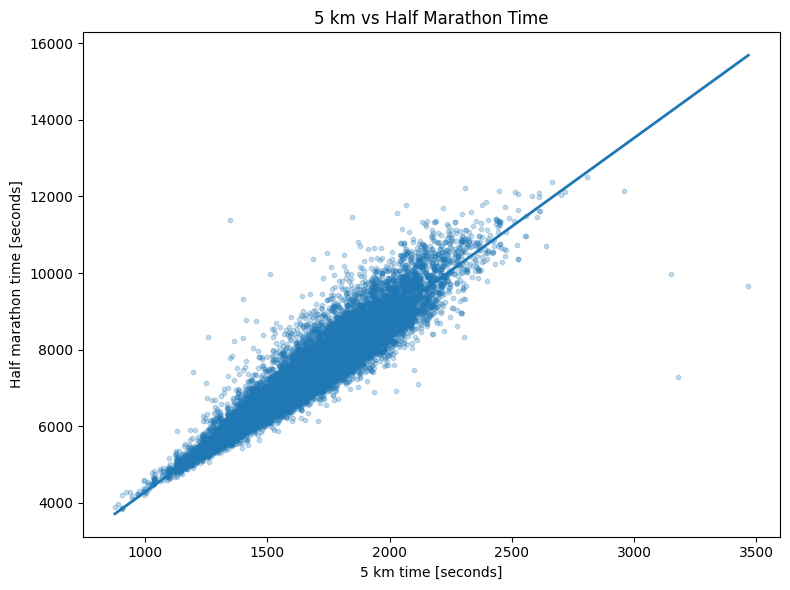

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# dane
x = train["t5k_s"].values
y = train["t21k_s"].values

# dopasowanie prostej (least squares)
coef = np.polyfit(x, y, 1)
trend = np.poly1d(coef)

print(f"Trend: t21k_s ≈ {coef[0]:.2f} * t5k_s + {coef[1]:.0f}")

# wykres
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.25, s=10)
plt.plot(
    np.sort(x),
    trend(np.sort(x)),
    linewidth=2
)

plt.xlabel("5 km time [seconds]")
plt.ylabel("Half marathon time [seconds]")
plt.title("5 km vs Half Marathon Time")

plt.tight_layout()
plt.show()


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# features / target
X = train[["t5k_s", "age"]].copy()
X["sex_M"] = (train["sex"] == "M").astype(int)  # 1 = M, 0 = K

y = train["t21k_s"]

# split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = LinearRegression()
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_val)

# metrics
mae_sec = mean_absolute_error(y_val, y_pred)
rmse_sec = mean_squared_error(y_val, y_pred) ** 0.5

print(f"MAE:  {mae_sec/60:.2f} min")
print(f"RMSE: {rmse_sec/60:.2f} min")

# współczynniki (ciekawostka)
coef = pd.Series(model.coef_, index=X.columns)
print("\nCoefficients:")
print(coef)
print("Intercept:", model.intercept_)


MAE:  4.99 min
RMSE: 6.80 min

Coefficients:
t5k_s    4.613135
age      1.200412
sex_M    8.082468
dtype: float64
Intercept: -377.1867875979324


In [12]:
from src.features import build_features

test = build_features(df_2023, 2023)
test.head(), test.shape


(  sex   age  t5k_s  t21k_s
 0   M  31.0  877.0  3899.0
 1   M  37.0  888.0  3983.0
 2   M  27.0  946.0  4104.0
 3   M  35.0  971.0  4216.0
 4   M  28.0  972.0  4227.0,
 (7913, 4))

In [13]:
from src.data import load_all_races

races = load_all_races((2023, 2024))
races[2023].shape, races[2024].shape

((8950, 27), (13007, 27))

In [14]:
from src.model import predict_halfmarathon_time

pred = predict_halfmarathon_time(
    t5k_s=25 * 60,  # 25:00
    age=40,
    sex="M",
)

pred / 60

109.97691624757319